In [119]:
import torch
import torch.nn.functional as F
import matplotlib.pyplot as plt # for making figures
%matplotlib inline

In [120]:
# read in all the words
words = open('names.txt', 'r').read().splitlines()
words[:8]

['emma', 'olivia', 'ava', 'isabella', 'sophia', 'charlotte', 'mia', 'amelia']

In [121]:
len(words)

32033

In [122]:
# build the vocabulary of characters and mappings 
chars = sorted(list(set(''.join(words))))
stoi = {s: i+1 for i, s in enumerate(chars)}
stoi['.'] = 0
itos = {i: s for s, i in stoi.items()}
print(itos)

{1: 'a', 2: 'b', 3: 'c', 4: 'd', 5: 'e', 6: 'f', 7: 'g', 8: 'h', 9: 'i', 10: 'j', 11: 'k', 12: 'l', 13: 'm', 14: 'n', 15: 'o', 16: 'p', 17: 'q', 18: 'r', 19: 's', 20: 't', 21: 'u', 22: 'v', 23: 'w', 24: 'x', 25: 'y', 26: 'z', 0: '.'}


In [123]:
# build the dataset

block_size = 3 # context length: how many characters do we take to predict the next one?
X, Y = [], []

for w in words[:3]:
    print(w)
    context = [0] * block_size
    for ch in w + '.':
        ix = stoi[ch]
        X.append(context)
        Y.append(ix)
        print(''.join(itos[i] for i in context), '--->', itos[ix])
        context = context[1:] + [ix] # crop and append

X = torch.tensor(X)
Y = torch.tensor(Y)

emma
... ---> e
..e ---> m
.em ---> m
emm ---> a
mma ---> .
olivia
... ---> o
..o ---> l
.ol ---> i
oli ---> v
liv ---> i
ivi ---> a
via ---> .
ava
... ---> a
..a ---> v
.av ---> a
ava ---> .


In [124]:
X.shape, X.dtype, Y.shape, Y.dtype

(torch.Size([16, 3]), torch.int64, torch.Size([16]), torch.int64)

In [125]:
# build the dataset

def build_dataset(words):
    block_size = 3 # context length: how many characters do we take to predict the next one?
    X, Y = [], []
    for w in words:

        # print(w)
        context = [0] * block_size
        for ch in w + '.':
            ix = stoi[ch]
            X.append(context)
            Y.append(ix)
            # print(''.join(itos[i] for i in context), '--->', itos[ix])
            context = context[1:] + [ix]

    X = torch.tensor(X)
    Y = torch.tensor(Y)
    print(X.shape, Y.shape)
    return X, Y

import random
random.seed(42)
random.shuffle(words)
n1 = int(0.8*len(words))
n2 = int(0.9*len(words))

Xtr, Ytr = build_dataset(words[:n1])
Xdev, Ydev = build_dataset(words[n1:n2])
Xte, Yte = build_dataset(words[n2:])

torch.Size([182625, 3]) torch.Size([182625])
torch.Size([22655, 3]) torch.Size([22655])
torch.Size([22866, 3]) torch.Size([22866])


In [ ]:
C = torch.randn((27, 2))

In [ ]:
emb = C[X] # takes each element i in X and returns C[i], aka the embedding for that character
emb.shape

In [ ]:
W1 = torch.randn((6, 100))
b1 = torch.randn(100)

In [ ]:
h = torch.tanh(emb.view(-1, 6) @ W1 + b1)

In [ ]:
h

In [ ]:
h.shape

In [ ]:
W2 = torch.randn((100, 27))
b2 = torch.randn(27)

In [ ]:
logits = h @ W2 + b2

In [ ]:
logits.shape

In [ ]:
counts = logits.exp()

In [ ]:
prob = counts / counts.sum(1, keepdim=True)

In [ ]:
prob.shape

In [ ]:
loss = -probs[torch.arange(32), Y].log().mean()
loss

In [ ]:
Y

In [62]:
# -------------------- now made respectable :) --------------------

In [82]:
Xtr.shape, Ytr.shape # dataset

(torch.Size([182625, 3]), torch.Size([182625]))

In [117]:
g = torch.Generator().manual_seed(2147483647) # for reproducibility
C = torch.randn((27, 10), generator=g)
W1 = torch.randn((30, 200), generator=g)
b1 = torch.randn(200, generator=g)
W2 = torch.randn((200, 27), generator=g)
b2 = torch.randn(27, generator=g)
parameters = [C, W1, b1, W2, b2]

In [106]:
sum(p.nelement() for p in parameters) # number of parameters in total

11897

In [107]:
for p in parameters:
    p.requires_grad = True

In [108]:
lre = torch.linspace(-3, 0, 1000)
lrs = 10**lre

In [109]:
lri = []
lossi = []
stepi = []

In [110]:
for i in range(200000):

    # minibatch constrcut
    ix = torch.randint(0, Xtr.shape[0], (32,))
    
    # forward pass
    emb = C[Xtr[ix]] # (32, 3, 2) or now it's (32, 3, 10)
    h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100) or now it's (32, 200)
    logits = h @ W2 + b2 # (32, 27)
    loss = F.cross_entropy(logits, Ytr[ix]) # 1) Forward and backward passes are more efficient 2) numerical well behaved (subtracting max value)
    # print(loss.item()) # minibatch loss
    
    # backward pass
    for p in parameters:
        p.grad = None
    loss.backward()
    
    # update
    # lr = lrs[i]
    lr = 0.1 if i < 100000 else 0.01
    for p in parameters:
        p.data += -lr * p.grad

    # track stats
    # lri.append(lre[i])
    stepi.append(i)
    lossi.append(loss.log10().item()) # works because loss is only for mini batch, technically for the previous learning rate

    if (i % 10000 == 0):
        print(loss.item())

# print(loss.item())

23.114824295043945
2.109757423400879
1.9618083238601685
2.209158182144165
2.5623064041137695
2.056187629699707
2.2014615535736084
2.4070239067077637
2.125105142593384
1.9022231101989746
2.3034353256225586
1.9793245792388916
2.772594690322876
1.8572413921356201
1.7836990356445312
1.951241135597229
2.1294474601745605
1.7830181121826172
1.9661378860473633
2.1138412952423096


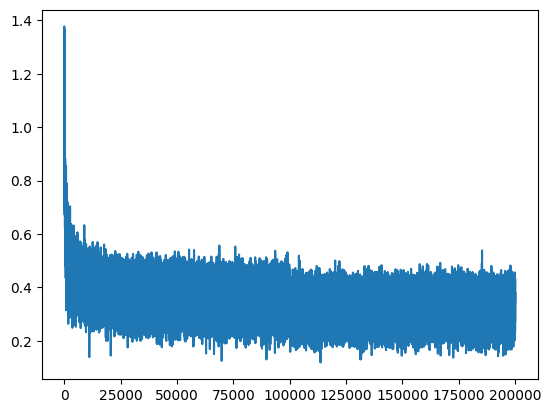

In [111]:
plt.plot(stepi, lossi)

In [112]:
emb = C[Xtr] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h@ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ytr)
loss

tensor(2.1125, grad_fn=<NllLossBackward0>)

In [113]:
emb = C[Xdev] # (32, 3, 2)
h = torch.tanh(emb.view(-1, 30) @ W1 + b1) # (32, 100)
logits = h@ W2 + b2 # (32, 27)
loss = F.cross_entropy(logits, Ydev)
loss

tensor(2.1509, grad_fn=<NllLossBackward0>)

In [1]:
plt.figure(figsize=(8,8))
plt.scatter(C[:, 0].data, C[:, 1].data, s=200)
for i in range(C.shape[0]):
    plt.text(C[i,0].item(), C[i,1].item(), itos[i], ha='center', va='center', color='white')
plt.grid('minor')

NameError: name 'plt' is not defined

In [115]:
# training split, dev/validation split, test split
# 80%, 10%, 10%

### sample from the model

In [116]:
g = torch.Generator().manual_seed(2147483647 + 10)

for _ in range(20):

    out = []
    context = [0] * block_size # initialize with all ...
    while True:
        emb = C[torch.tensor([context])] # (1, block_size, d)
        h = torch.tanh(emb.view(1, -1) @ W1 + b1)
        logits = h @ W2 + b2
        probs = F.softmax(logits, dim=1)
        ix = torch.multinomial(probs, num_samples=1, generator=g).item()
        context = context[1:] + [ix]
        out.append(ix)
        if ix == 0:
            break
    print(''.join(itos[i] for i in out))

carlah.
americk.
hirmin.
reh.
caspley.
kenlahnen.
deliah.
jareen.
nezekia.
chriiv.
kaleigh.
ham.
porn.
quint.
sulin.
alianni.
wajerma.
jaryn.
kai.
evidgracee.


In [142]:
class Example:

    def __init__(self):
        print('initialized')

    def __repr__(self):
        # print('representation1')
        return 'representation 1'

    def __add__(self, other):
        print('function called')
        # x = lambda : 'rep 2'
        Example.__repr__ = lambda self: 'rep 2'
        return self

In [143]:
a = Example()
b = Example()
print(a)
a + b
a

initialized
initialized
representation 1
function called


rep 2